<a href="https://colab.research.google.com/github/Anudeepsadda/Malicious_URL_Detection_with_ML_Ensemble/blob/main/ML_Ensemble_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install -U datasets

In [ ]:
%%bash
pip install torch_optimizer numpy torch transformers evaluate python-whois --quiet
# The --quiet option is used to suppress the output of a pip command

In [ ]:
from datasets import load_dataset
from datasets import Dataset
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Import label encoder
from sklearn import preprocessing, metrics

In [ ]:
import itertools
from sklearn.metrics import classification_report, mean_squared_error,confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, auc,roc_curve
from sklearn.model_selection import train_test_split
import random
import math
from collections import Counter
import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import os
import socket
import whois
from datetime import datetime
import time
from bs4 import BeautifulSoup
import urllib
import bs4
import os

In [ ]:
df = pd.read_csv('/content/malicious_phish.csv', encoding='latin-1')
# or 'iso-8859-1' or any other encoding that might work for your data

In [ ]:
print(df.shape)

(651191, 2)


In [ ]:
print(df.head)

<bound method NDFrame.head of                                                       url        type
0                                        br-icloud.com.br    phishing
1                     mp3raid.com/music/krizz_kaliko.html      benign
2                         bopsecrets.org/rexroth/cr/1.htm      benign
3       http://www.garage-pirenne.be/index.php?option=...  defacement
4       http://adventure-nicaragua.net/index.php?optio...  defacement
...                                                   ...         ...
651186            xbox360.ign.com/objects/850/850402.html    phishing
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing
651188         www.gamespot.com/xbox360/action/deadspace/    phishing
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing
651190          www.angelfire.com/goth/devilmaycrytonite/    phishing

[651191 rows x 2 columns]>


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651188 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None


In [ ]:
df.groupby('type').apply(lambda x: x.sample(1)).reset_index(drop=True)

,url,type
0,www.debbiereynoldsonline.com/wp-content//theme...,benign
1,http://www.auter.co.rs/index.php?option=com_ma...,defacement
2,http://onlink-aoiuvr.com/Shipment-Invoice.jar,malware
3,www.faqs.org/faqs/graphics/algorithms-faq/,phishing


In [ ]:
df.isna().sum()


,0
url,0
type,3


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
types = df['type'].values

In [ ]:
counter_types = Counter(types)

In [ ]:
type_names = list(counter_types.keys())
type_values = list(counter_types.values())

In [ ]:
sorted_indices = np.argsort(type_values)[::-1]
type_names = [type_names[i] for i in sorted_indices]
type_values = [type_values[i] for i in sorted_indices]

In [ ]:
total_count = sum(type_values)
percentages = [value / total_count * 100 for value in type_values]

In [ ]:
pattern = '//'

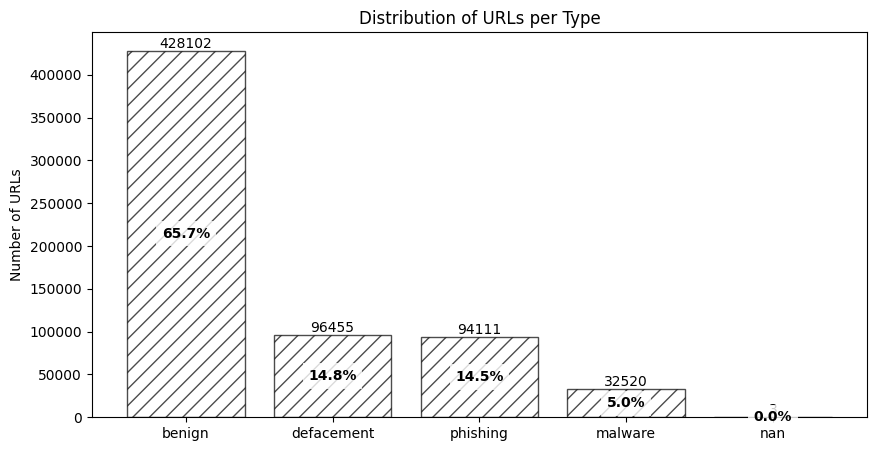

In [ ]:
y_pos = np.arange(len(type_names))
plt.figure(1, figsize=(10, 5))
bars = plt.bar(y_pos, type_values, align='center', alpha=0.7, color='none', edgecolor='black', hatch=pattern)

for bar, value, percentage in zip(bars, type_values, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{value}', ha='center', va='bottom')
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{percentage:.1f}%', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'), fontweight='bold')

plt.xticks(y_pos, type_names)
plt.ylabel('Number of URLs')
plt.title('Distribution of URLs per Type')
plt.show()

In [ ]:
print(counter_types)

Counter({'benign': 428102, 'defacement': 96455, 'phishing': 94111, 'malware': 32520, nan: 3})


In [ ]:
df['url_len'] = [len(url) for url in df.url]
df.head()

,url,type,url_len
0,br-icloud.com.br,phishing,16
1,mp3raid.com/music/krizz_kaliko.html,benign,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,31
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235


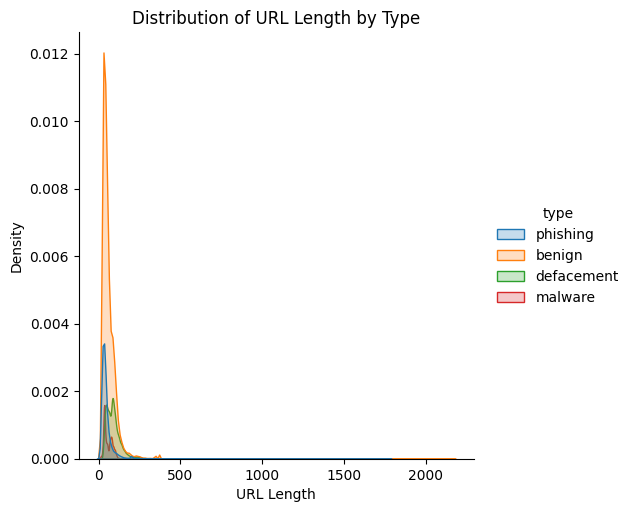

In [ ]:
# Plot distribution of 'url_len' for each 'type'
sns.displot(df, x='url_len', hue='type', kind='kde', fill=True)

# Add labels and title
plt.xlabel('URL Length')
plt.ylabel('Density')
plt.title('Distribution of URL Length by Type')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le= LabelEncoder()
le.fit(df["type"])

df["type_code"] = le.transform(df["type"])
df

,url,type,url_len,type_code
0,br-icloud.com.br,phishing,16,3
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,1
...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,39,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,44,3
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,42,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,45,3


In [ ]:
le_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_label_mapping

{'benign': 0, 'defacement': 1, 'malware': 2, 'phishing': 3, nan: 4}

In [ ]:
df = df[['url', 'type', 'type_code']]
dataset = Dataset.from_pandas(df, preserve_index=False)
dataset

Dataset({
    features: ['url', 'type', 'type_code'],
    num_rows: 651191
})

In [ ]:
# split train to 80% of total and test to 20% of total
train_test_dataset = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_test_dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 520952
    })
    test: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 130239
    })
})

In [ ]:
# split the validation test to 10% of total and test set to 10% of total
val_test_dataset = train_test_dataset['test'].train_test_split(test_size=0.5, seed=42, shuffle=True)
val_test_dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 65119
    })
    test: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 65120
    })
})

In [ ]:
from datasets import DatasetDict

In [ ]:
# 80% train, 10% validation, 10% test
dataset = DatasetDict({
    'train': train_test_dataset['train'],
    'val': val_test_dataset['train'],
    'test': val_test_dataset['test'],
})
dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 520952
    })
    val: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 65119
    })
    test: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 65120
    })
})

In [ ]:
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_val = pd.DataFrame(dataset['val'])

In [ ]:
import re

In [ ]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df_train['use_of_ip'] = df_train['url'].apply(lambda i: having_ip_address(i))
df_test['use_of_ip'] = df_test['url'].apply(lambda i: having_ip_address(i))

df_train

,url,type,type_code,use_of_ip
0,tools.ietf.org/html/rfc1328,phishing,3,0
1,twnty.com/,benign,0,0
2,pianoplus.ca/,benign,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0
...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0


In [ ]:
from urllib.parse import urlparse

In [ ]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [ ]:
df_train['abnormal_url'] = df_train['url'].apply(lambda i: abnormal_url(i))
df_test['abnormal_url'] = df_test['url'].apply(lambda i: abnormal_url(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url
0,tools.ietf.org/html/rfc1328,phishing,3,0,0
1,twnty.com/,benign,0,0,0
2,pianoplus.ca/,benign,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0
...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1


In [ ]:
df_train['count.'] = df_train['url'].apply(lambda i: i.count('.'))
df_test['count.'] = df_test['url'].apply(lambda i: i.count('.'))

df_train.head()

,url,type,type_code,use_of_ip,abnormal_url,count.
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2
1,twnty.com/,benign,0,0,0,1
2,pianoplus.ca/,benign,0,0,0,1
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3


In [ ]:
df_train['count-www'] = df_train['url'].apply(lambda i: i.count('www'))
df_test['count-www'] = df_test['url'].apply(lambda i: i.count('www'))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0
1,twnty.com/,benign,0,0,0,1,0
2,pianoplus.ca/,benign,0,0,0,1,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0
...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0


In [ ]:
df_train['count@'] = df_train['url'].apply(lambda i: i.count('@'))
df_test['count@'] = df_test['url'].apply(lambda i: i.count('@'))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0
1,twnty.com/,benign,0,0,0,1,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0
...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0


In [ ]:
from urllib.parse import urlparse
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df_train['count_dir'] = df_train['url'].apply(lambda i: no_of_dir(i))
df_test['count_dir'] = df_test['url'].apply(lambda i: no_of_dir(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2
1,twnty.com/,benign,0,0,0,1,0,0,1
2,pianoplus.ca/,benign,0,0,0,1,0,0,1
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7
...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2


In [ ]:
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df_train['count_embed_domian'] = df_train['url'].apply(lambda i: no_of_embed(i))
df_test['count_embed_domian'] = df_test['url'].apply(lambda i: no_of_embed(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0
...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0


In [ ]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0

df_train['sus_url'] = df_train['url'].apply(lambda i: suspicious_words(i))
df_test['sus_url'] = df_test['url'].apply(lambda i: suspicious_words(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0


In [ ]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df_train['short_url'] = df_train['url'].apply(lambda i: shortening_service(i))
df_test['short_url'] = df_test['url'].apply(lambda i: shortening_service(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0


In [ ]:
df_train['count-https'] = df_train['url'].apply(lambda i : i.count('https'))
df_test['count-https'] = df_test['url'].apply(lambda i : i.count('https'))
df_train


,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0


In [ ]:
df_train['count-http'] = df_train['url'].apply(lambda i : i.count('http'))
df_test['count-http'] = df_test['url'].apply(lambda i : i.count('http'))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1


In [ ]:
df_train['count%'] = df_train['url'].apply(lambda i: i.count('%'))
df_test['count%'] = df_test['url'].apply(lambda i: i.count('%'))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0


In [ ]:
df_train['count-'] = df_train['url'].apply(lambda i: i.count('-'))
df_test['count-'] = df_test['url'].apply(lambda i: i.count('-'))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0


In [ ]:
df_train['count='] = df_train['url'].apply(lambda i: i.count('='))
df_test['count='] = df_test['url'].apply(lambda i: i.count('='))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1


In [ ]:
df_train['url_length'] = df_train['url'].apply(lambda i: len(str(i)))
df_test['url_length'] = df_test['url'].apply(lambda i: len(str(i)))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=,url_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,27
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,10
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,13
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0,68
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0,80
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0,100
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0,46
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1,123


In [ ]:
df_train['hostname_length'] = df_train['url'].apply(lambda i: len(urlparse(i).netloc))
df_test['hostname_length'] = df_test['url'].apply(lambda i: len(urlparse(i).netloc))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=,url_length,hostname_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,27,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,10,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,13,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0,68,19
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0,55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0,80,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0,100,7
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0,46,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1,123,12


In [ ]:
!pip install tld

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

In [ ]:
#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df_train['fd_length'] = df_train['url'].apply(lambda i: fd_length(i))
df_test['fd_length'] = df_test['url'].apply(lambda i: fd_length(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=,url_length,hostname_length,fd_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,27,0,4
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,10,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,13,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0,68,19,18
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0,55,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0,80,0,4
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0,100,7,8
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0,46,0,3
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1,123,12,7


In [ ]:
#Length of Top Level Domain
df_train['tld'] = df_train['url'].apply(lambda i: get_tld(i,fail_silently=True))
df_test['tld'] = df_test['url'].apply(lambda i: get_tld(i,fail_silently=True))

def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df_train['tld_length'] = df_train['tld'].apply(lambda i: tld_length(i))
df_test['tld_length'] = df_test['tld'].apply(lambda i: tld_length(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-https,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld,tld_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,0,27,0,4,None,-1
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,0,10,0,0,None,-1
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,0,13,0,0,None,-1
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,0,1,0,3,0,68,19,18,dk,2
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,0,55,0,4,None,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,0,0,7,0,80,0,4,None,-1
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,0,1,0,12,0,100,7,8,com,3
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,0,0,6,0,46,0,3,None,-1
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,0,1,0,0,1,123,12,7,net,3


In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

df_train['count-digits']= df_train['url'].apply(lambda i: digit_count(i))
df_test['count-digits']= df_test['url'].apply(lambda i: digit_count(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld,tld_length,count-digits
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,27,0,4,None,-1,4
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,10,0,0,None,-1,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,13,0,0,None,-1,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,1,0,3,0,68,19,18,dk,2,9
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,55,0,4,None,-1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,0,7,0,80,0,4,None,-1,10
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,1,0,12,0,100,7,8,com,3,6
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,0,6,0,46,0,3,None,-1,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,1,0,0,1,123,12,7,net,3,33


In [ ]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df_train['count-letters']= df_train['url'].apply(lambda i: letter_count(i))
df_test['count-letters']= df_test['url'].apply(lambda i: letter_count(i))
df_train


,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count%,count-,count=,url_length,hostname_length,fd_length,tld,tld_length,count-digits,count-letters
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,27,0,4,None,-1,4,19
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,10,0,0,None,-1,0,8
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,13,0,0,None,-1,0,11
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,0,3,0,68,19,18,dk,2,9,46
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,55,0,4,None,-1,8,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,7,0,80,0,4,None,-1,10,57
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,0,12,0,100,7,8,com,3,6,75
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,6,0,46,0,3,None,-1,0,37
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,0,0,1,123,12,7,net,3,33,74


In [ ]:
df_train = df_train.drop("tld",axis=1)
df_test = df_test.drop("tld",axis=1)
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld_length,count-digits,count-letters
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,27,0,4,-1,4,19
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,10,0,0,-1,0,8
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,13,0,0,-1,0,11
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,1,0,3,0,68,19,18,2,9,46
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,55,0,4,-1,8,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,0,7,0,80,0,4,-1,10,57
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,1,0,12,0,100,7,8,3,6,75
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,0,6,0,46,0,3,-1,0,37
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,1,0,0,1,123,12,7,3,33,74


In [ ]:
df_train.head()

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld_length,count-digits,count-letters
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,27,0,4,-1,4,19
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,10,0,0,-1,0,8
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,13,0,0,-1,0,11
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,1,0,3,0,68,19,18,2,9,46
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,55,0,4,-1,8,37


In [ ]:
#Predictor Variables
X_train = df_train[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
# Check the name of the target variable column in your dataframe.
# It might be 'result', 'type', 'label', or something similar.
# Replace 'labels' with the correct column name.
# For example, if the target variable column is named 'result':
# Instead of assuming the column is named 'result', print the columns
# to see the actual column names:
print(df_train.columns)

# Based on the printed columns, select the correct target variable column
# For example, if the target variable column is named 'type':
y_train = df_train['type']
# If it's named something else, replace 'type' with the actual name.

# Print the available columns to be sure.
print(df_train.columns)

Index(['url', 'type', 'type_code', 'use_of_ip', 'abnormal_url', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'sus_url',
       'short_url', 'count-https', 'count-http', 'count%', 'count-', 'count=',
       'url_length', 'hostname_length', 'fd_length', 'tld_length',
       'count-digits', 'count-letters'],
      dtype='object')
Index(['url', 'type', 'type_code', 'use_of_ip', 'abnormal_url', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'sus_url',
       'short_url', 'count-https', 'count-http', 'count%', 'count-', 'count=',
       'url_length', 'hostname_length', 'fd_length', 'tld_length',
       'count-digits', 'count-letters'],
      dtype='object')


In [ ]:
#Predictor Variables
X_test = df_test[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
# Instead of assuming the column is named 'labels', print the columns
# to see the actual column names:
print(df_test.columns)

# Based on the printed columns, select the correct target variable column
# For example, if the target variable column is named 'type':
y_test = df_test['type']
# If it's named something else, replace 'type' with the actual name.

Index(['url', 'type', 'type_code', 'use_of_ip', 'abnormal_url', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'sus_url',
       'short_url', 'count-https', 'count-http', 'count%', 'count-', 'count=',
       'url_length', 'hostname_length', 'fd_length', 'tld_length',
       'count-digits', 'count-letters'],
      dtype='object')


In [ ]:
X_train.to_csv('./x-train.csv')
y_train.to_csv('./y-train.csv')
X_test.to_csv('./x-test.csv')
y_test.to_csv('./y-test.csv')

In [ ]:
eval_df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-macro', 'F1-micro', 'F1-weighted'])
eval_df

,Model,Accuracy,F1-macro,F1-micro,F1-weighted


In [ ]:
print(X_train.isna().sum())  # Check for missing values in features
print(y_train.isna().sum())  # Check for missing values in labels

use_of_ip             0
abnormal_url          0
count.                0
count-www             0
count@                0
count_dir             0
count_embed_domian    0
short_url             0
count-https           0
count-http            0
count%                0
count-                0
count=                0
url_length            0
hostname_length       0
sus_url               0
fd_length             0
tld_length            0
count-digits          0
count-letters         0
dtype: int64
3


In [ ]:
print(X_train.dtypes)
print(y_train.dtypes)

use_of_ip             int64
abnormal_url          int64
count.                int64
count-www             int64
count@                int64
count_dir             int64
count_embed_domian    int64
short_url             int64
count-https           int64
count-http            int64
count%                int64
count-                int64
count=                int64
url_length            int64
hostname_length       int64
sus_url               int64
fd_length             int64
tld_length            int64
count-digits          int64
count-letters         int64
dtype: object
object


In [ ]:
print(X_train.dtypes)
print(y_train.dtypes)

use_of_ip             int64
abnormal_url          int64
count.                int64
count-www             int64
count@                int64
count_dir             int64
count_embed_domian    int64
short_url             int64
count-https           int64
count-http            int64
count%                int64
count-                int64
count=                int64
url_length            int64
hostname_length       int64
sus_url               int64
fd_length             int64
tld_length            int64
count-digits          int64
count-letters         int64
dtype: object
object


In [ ]:
X_train = X_train.fillna(0)  # Replace NaNs with 0, or choose an appropriate value
y_train = y_train.fillna(method='ffill')  # Fill labels if applicable

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
lgb = LGBMClassifier(objective='multiclass', boosting_type='gbdt', n_jobs=5, silent=True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 20
[LightGBM] [Info] Start training from score -0.419976
[LightGBM] [Info] Start training from score -1.909466
[LightGBM] [Info] Start training from score -2.995947
[LightGBM] [Info] Start training from score -1.932479


In [ ]:
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5,
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)

y_predLGB = LGB_C.predict(X_test)
print(classification_report(y_test,y_predLGB))

score = metrics.accuracy_score(y_test, y_predLGB)
print("accuracy:   %0.3f" % score)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 20
[LightGBM] [Info] Start training from score -0.419976
[LightGBM] [Info] Start training from score -1.909466
[LightGBM] [Info] Start training from score -2.995947
[LightGBM] [Info] Start training from score -1.932479
[LightGBM] [Warning] Unknown parameter: silent
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42951
           1       0.96      0.99      0.98      9557
           2       0.97      0.91      0.94      3253
           3       0.91      0.83      0.87      9359

    accuracy                           0.96     65120
   macro avg       0.95    

In [ ]:
lgbm_acc = accuracy_score(y_test, y_predLGB)
lgbm_acc

0.9606572481572482

In [ ]:
lgbm_f1_macro = f1_score(y_test, y_predLGB, average='macro')
lgbm_f1_macro

0.9405333733784825

In [ ]:
lgbm_f1_micro = f1_score(y_test, y_predLGB, average='micro')
lgbm_f1_micro

0.9606572481572482

In [ ]:
lgbm_f1_w = f1_score(y_test, y_predLGB, average='weighted')
lgbm_f1_w

0.9599497316830741

In [ ]:
new_eval = {'Model': 'LGBM','Accuracy': lgbm_acc, 'F1-macro': lgbm_f1_macro, 'F1-micro': lgbm_f1_micro, 'F1-weighted': lgbm_f1_w }
eval_df.loc[len(eval_df)] = new_eval

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder to the unique classes in y_test
le.fit(np.unique(y_test))

# Transform both y_test and y_predLGB using the encoder
y_test_encoded = le.transform(y_test)
y_predLGB_encoded = le.transform(y_predLGB)


In [ ]:
lgb_feature = lgb.feature_importances_
lgb_feature

array([  25,   50, 1011,  493,   67, 1142,   48,  134,  251,  167,  229,
        598,  514, 1080, 1495,  252, 1783,  630, 1202,  829], dtype=int32)

In [ ]:
lgb_features = lgb_feature.tolist()

XGBoost

In [ ]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb  # Import the xgboost library directly
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report


# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder to the unique classes in BOTH y_train and y_test
# This ensures all possible labels are included
le.fit(np.unique(np.concatenate((y_train, y_test))))

# Transform both y_train and y_test using the encoder
y_train = le.transform(y_train)
y_test = le.transform(y_test)

# Now, y_train and y_test will contain numerical labels instead of strings.

# Proceed with fitting the XGBClassifier
# Initialize the XGBClassifier directly using xgboost.XGBClassifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100)
xgb_classifier.fit(X_train, y_train)  # Fit using the new variable name
y_predXGB = xgb_classifier.predict(X_test)  # Predict using the new variable name
print(classification_report(y_test, y_predXGB))


score = metrics.accuracy_score(y_test, y_predXGB)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42951
           1       0.97      0.99      0.98      9557
           2       0.98      0.93      0.95      3253
           3       0.91      0.84      0.87      9359

    accuracy                           0.96     65120
   macro avg       0.96      0.94      0.95     65120
weighted avg       0.96      0.96      0.96     65120

accuracy:   0.963


In [ ]:
xgb_acc = accuracy_score(y_test, y_predXGB)
xgb_acc

0.9634060196560197

In [ ]:
xgb_f1_macro = f1_score(y_test, y_predXGB, average='macro')
xgb_f1_macro

0.9470101419786336

In [ ]:
xgb_f1_micro = f1_score(y_test, y_predXGB, average='micro')
xgb_f1_micro

0.9634060196560197

In [ ]:
xgb_f1_w = f1_score(y_test, y_predXGB, average='weighted')
xgb_f1_w

0.96272731310944

In [ ]:
new_eval = {'Model': 'XGB','Accuracy': xgb_acc, 'F1-macro': xgb_f1_macro, 'F1-micro': xgb_f1_micro, 'F1-weighted': xgb_f1_w }
eval_df.loc[len(eval_df)] = new_eval

Confusion matrix, without normalization


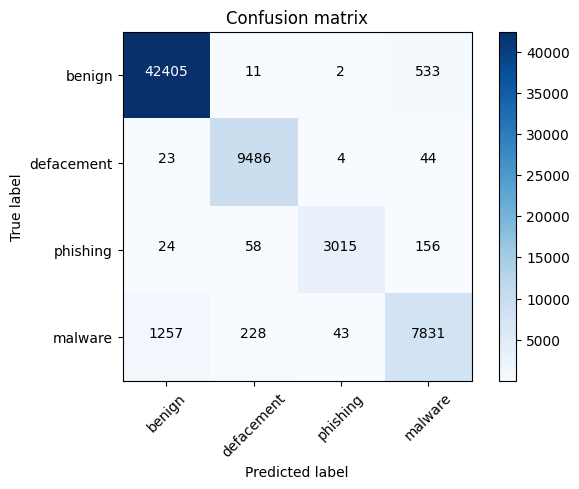

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
CM = confusion_matrix(y_test, y_predXGB, labels=[0, 1, 2, 3])

# Plot the confusion matrix
plot_confusion_matrix(CM, classes=['benign', 'defacement', 'phishing', 'malware'])

In [ ]:
from xgboost import XGBClassifier  # or XGBRegressor, depending on your task
# ... (your other imports and code) ...

# Assuming 'X_train' and 'y_train' are your training data
xgb = XGBClassifier() # Instantiate your XGBoost model
xgb.fit(X_train, y_train) # Fit the model to your training data

xgb_feature = xgb.feature_importances_ # Now access feature_importances_ from the fitted model
xgb_features = xgb_feature.tolist()

Gradientt Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier(n_estimators=100,max_features='sqrt')
gbdt.fit(X_train,y_train)
y_predGBDT = gbdt.predict(X_test)
print(classification_report(y_test,y_predGBDT))

score = metrics.accuracy_score(y_test, y_predGBDT)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     42951
           1       0.90      0.97      0.94      9557
           2       0.93      0.80      0.86      3253
           3       0.89      0.75      0.81      9359

    accuracy                           0.94     65120
   macro avg       0.92      0.88      0.90     65120
weighted avg       0.94      0.94      0.94     65120

accuracy:   0.940


In [ ]:
gbdt_acc = accuracy_score(y_test, y_predGBDT)
gbdt_acc

0.9398955773955774

In [ ]:
gbdt_f1_macro = f1_score(y_test, y_predGBDT, average='macro')
gbdt_f1_macro

0.8954104275136116

In [ ]:
gbdt_f1_micro = f1_score(y_test, y_predGBDT, average='micro')
gbdt_f1_micro

0.9398955773955774

In [ ]:
gbdt_f1_w = f1_score(y_test, y_predGBDT, average='weighted')
gbdt_f1_w

0.9379296267606203

In [ ]:
new_eval = {'Model': 'GBDT','Accuracy': gbdt_acc, 'F1-macro': gbdt_f1_macro, 'F1-micro': gbdt_f1_micro, 'F1-weighted': gbdt_f1_w }
eval_df.loc[len(eval_df)] = new_eval

Confusion matrix, without normalization


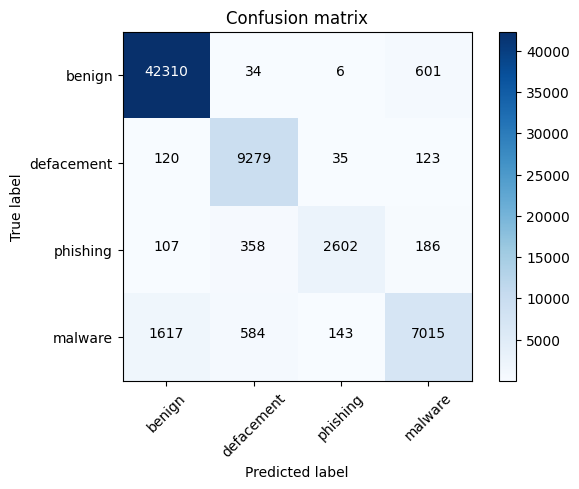

In [ ]:
# Compute the confusion matrix
CM = confusion_matrix(y_test, y_predGBDT, labels=[0, 1, 2, 3])

# Plot the confusion matrix
plot_confusion_matrix(CM, classes=['benign', 'defacement', 'phishing', 'malware'])

In [ ]:
gbdt_feature = gbdt.feature_importances_
gbdt_features = gbdt_feature.tolist()

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
y_predRF = rf.predict(X_test)
print(classification_report(y_test,y_predRF))

score = metrics.accuracy_score(y_test, y_predRF)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     42951
           1       0.98      0.99      0.99      9557
           2       0.99      0.95      0.97      3253
           3       0.91      0.86      0.89      9359

    accuracy                           0.97     65120
   macro avg       0.96      0.95      0.96     65120
weighted avg       0.97      0.97      0.97     65120

accuracy:   0.967


In [ ]:
rf_acc = accuracy_score(y_test, y_predRF)
rf_acc

0.967014742014742

In [ ]:
rf_f1_macro = f1_score(y_test, y_predRF, average='macro')
rf_f1_macro

0.9550849981740293

In [ ]:
rf_f1_micro = f1_score(y_test, y_predRF, average='micro')
rf_f1_micro

0.967014742014742

In [ ]:
rf_f1_w = f1_score(y_test, y_predRF, average='weighted')
rf_f1_w

0.9666632035650004

In [ ]:
new_eval = {'Model': 'RF','Accuracy': rf_acc, 'F1-macro': rf_f1_macro, 'F1-micro': rf_f1_micro, 'F1-weighted': rf_f1_w }
eval_df.loc[len(eval_df)] = new_eval

Confusion matrix, without normalization


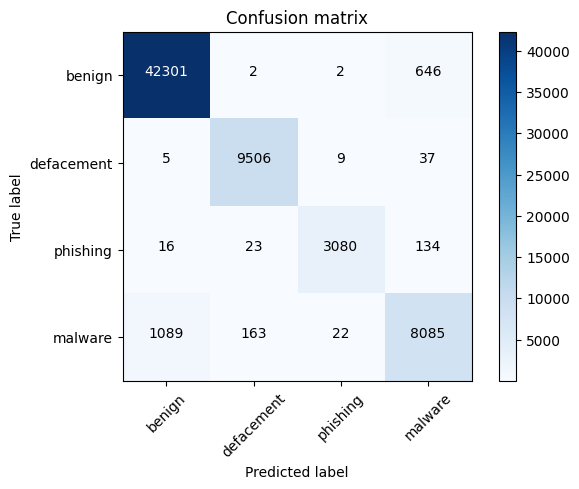

In [ ]:
CM = confusion_matrix(y_test, y_predRF, labels=[0, 1, 2, 3])

# Use CM in the function call
plot_confusion_matrix(CM, classes=['benign', 'defacement', 'phishing', 'malware'])

In [ ]:
rf_feature = rf.feature_importances_
rf_features = rf_feature.tolist()

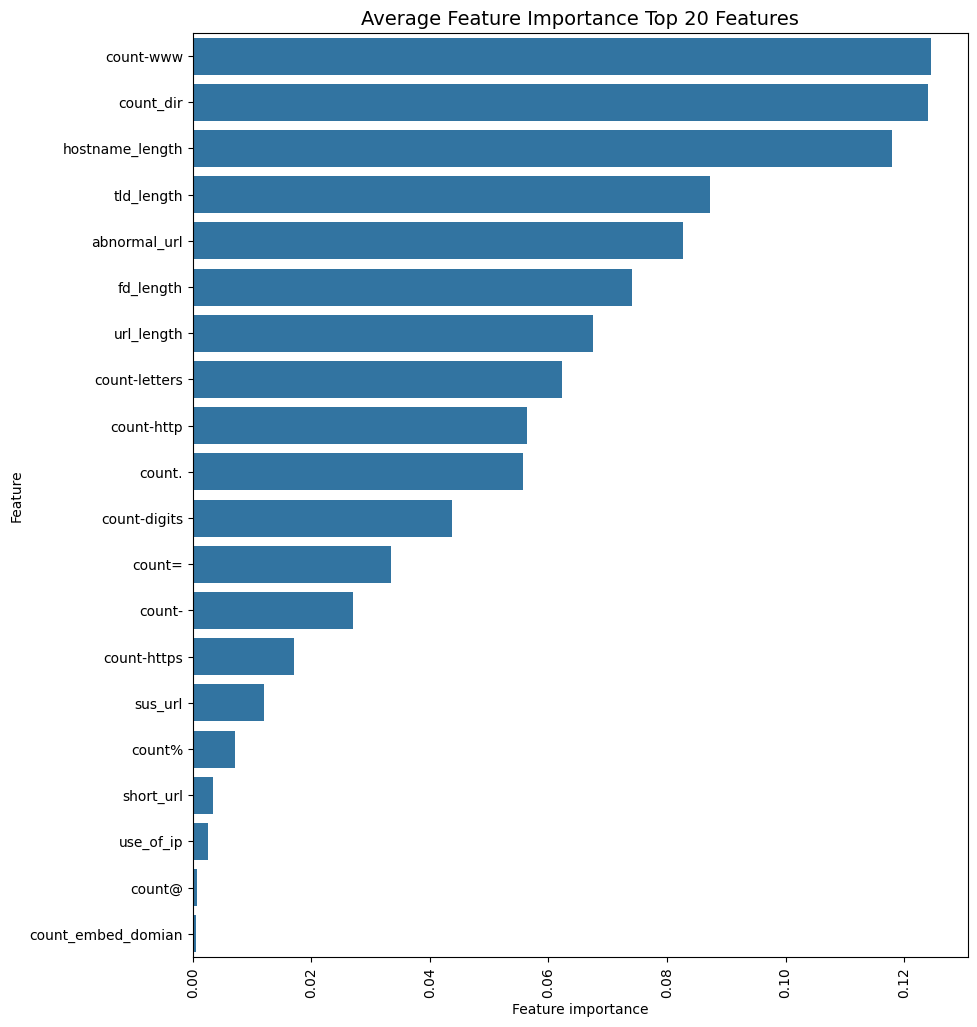

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Importing pandas for DataFrame operations
%matplotlib inline

def plot_feature_importance():
    # Creating feature_dataframe from rf_features and X_test.columns
    # Assuming rf_features contains feature importances from a model
    feature_dataframe = pd.DataFrame({'mean': rf_features}, index=X_test.columns)

    tmp = pd.DataFrame({'Feature': X_test.columns, 'Feature importance': feature_dataframe['mean'].values})
    tmp = tmp.sort_values(by='Feature importance',ascending=False).head(20)
    plt.figure(figsize = (10,12))
    plt.title('Average Feature Importance Top 20 Features',fontsize=14)
    s = sns.barplot(y='Feature',x='Feature importance',data=tmp, orient='h')
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

plot_feature_importance()

In [ ]:
eval_df.sort_values(by=['F1-weighted','Accuracy'], ascending=False)

,Model,Accuracy,F1-macro,F1-micro,F1-weighted
4,RF,0.967015,0.955085,0.967015,0.966663
1,XGB,0.963406,0.947010,0.963406,0.962727
0,LGBM,0.960657,0.940533,0.960657,0.959950
2,GBDT,0.939896,0.895410,0.939896,0.937930
3,GBDT,0.939896,0.895410,0.939896,0.937930


In [ ]:
eval_df.to_csv('./eval-df.csv')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Data for the graph
data = {
    "Model": ["RF", "XGB", "LGBM", "GBDT"],
    "Accuracy": [0.967015, 0.963406, 0.960657, 0.939896]
}

In [ ]:
# Create a DataFrame
eval_df = pd.DataFrame(data)

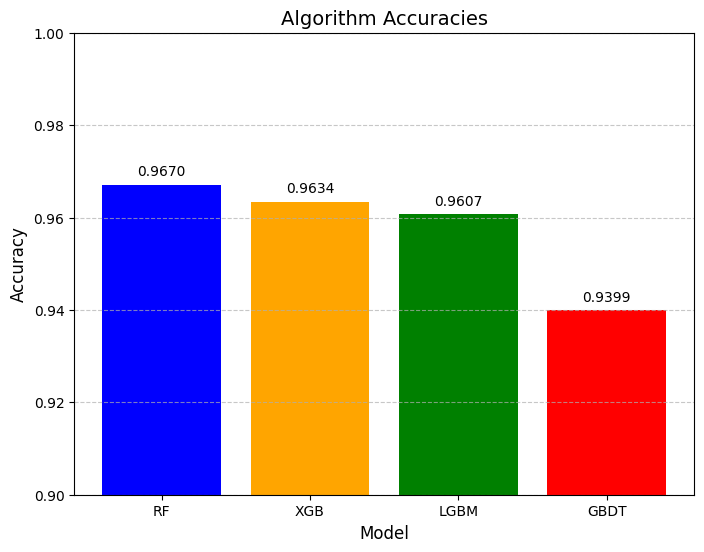

In [ ]:
# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(eval_df['Model'], eval_df['Accuracy'], color=['blue', 'orange', 'green', 'red'])

# Adding labels and title
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Algorithm Accuracies", fontsize=14)
plt.ylim(0.9, 1.0)  # Adjust y-axis for better visibility

# Display the values on top of bars
for i, val in enumerate(eval_df['Accuracy']):
    plt.text(i, val + 0.002, f"{val:.4f}", ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Assuming `y_test` and `y_pred_probs` are defined
# Binarizing the labels for multi-class ROC
classes = ['benign', 'defacement', 'phishing', 'malware']
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])  # Update with your class indices

# Plotting ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])  # Adjust `y_pred_probs` appropriately
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

# Plotting the diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-Class ROC Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

NameError: name 'y_pred_probs' is not defined

<Figure size 1000x800 with 0 Axes>